In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize


def mnk_intercept(X, Y, resolution=10000):
    if isinstance(X, pd.Series):
        X = X.to_numpy()
    if isinstance(Y, pd.Series):
        Y = Y.to_numpy()

    a = (X@Y)/(X@X)
    min_loss = np.sum((Y - a * X)**2)

    def relative_loss(delta):
        return np.sum((Y - (a + delta) * X)**2) / min_loss

    delta = 0

    step = a / resolution
    while relative_loss(delta) < 2:
        delta += step

    def f(x):
        return a * x

    return a, delta, f


def mnk(X, Y):
    a, b = np.polyfit(X, Y, deg=1)

    S_x = np.std(X) ** 2
    S_y = np.std(Y) ** 2
    da = 2 * np.sqrt((S_y/S_x - a ** 2)/(len(X) - 2))
    db = da * np.sqrt(np.mean(X**2))

    def f(x):
        return a*x + b

    return a, b, da, db, f


def chi_fit(X, Y, dY, sigma=1, force_intercept=False):
    """
    Does linear regression y = ax + b using least chi square method

    returns a, b, da, db
    """

    if len(X) != len(Y):
        raise ValueError("dimensons of X and Y don't match")

    L = len(X)

    if force_intercept:
        def f(a):
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i])) / dY[i]

            return ret

        result = scipy.optimize.least_squares(
            f, (1,), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_):
            return np.sum(f((a_))**2)

        da = 0
        inc_a = a/10000

        while sigma > chi_2(a+da) - chi_2_min:
            da += inc_a

        def linear_f(x):
            return a*x

        return a, 0, da, 0, linear_f, chi_2_min
    else:
        def f(coeffs):
            a, b = coeffs
            ret = np.zeros(L, dtype=float)

            for i in range(L):
                ret[i] = (Y[i] - (a*X[i] + b)) / dY[i]

            return ret

        result = scipy.optimize.least_squares(
            f, (1, 1), ftol=1e-15, xtol=1e-15, gtol=1e-15)
        a, b = result['x']
        chi_2_min = result['cost'] * 2

        def chi_2(a_, b_):
            return np.sum(f((a_, b_))**2)

        da, db = 0, 0
        inc_a = a/10000
        inc_b = b/10000

        while sigma > chi_2(a+da, b) - chi_2_min:
            da += inc_a

        while sigma > chi_2(a, b+db) - chi_2_min:
            db += inc_b

        def linear_f(x):
            return a*x + b

        return a, b, da, db, linear_f, chi_2_min

In [13]:
low_freq = pd.read_csv('low_freq.csv')
low_freq['xi'] = low_freq['U'] / (low_freq['f'] * low_freq['I'])
low_freq.head()

,f,I,U,xi
0,25,473.18,162.1,0.013703
1,30,471.12,192.8,0.013641
2,35,468.87,222.6,0.013565
3,40,466.29,251.4,0.013479
4,45,463.40,279.1,0.013384


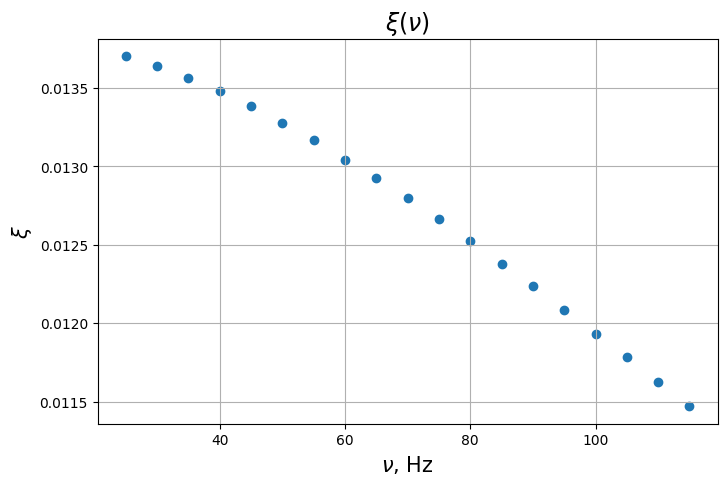

In [14]:
plt.figure(figsize=(8,5))
plt.grid()
plt.title(r"$\xi(\nu)$", fontsize=17)
plt.xlabel(r"$\nu$, Hz", fontsize=15)
plt.ylabel(r"$\xi$", fontsize=15)
plt.scatter(low_freq['f'], low_freq['xi'])

# plt.savefig('../pictures/xi_nu_low_freq.eps')
plt.show()

0.18034106814476747 0.0004888253623682819 5218.2297565551435 3.353667972338594


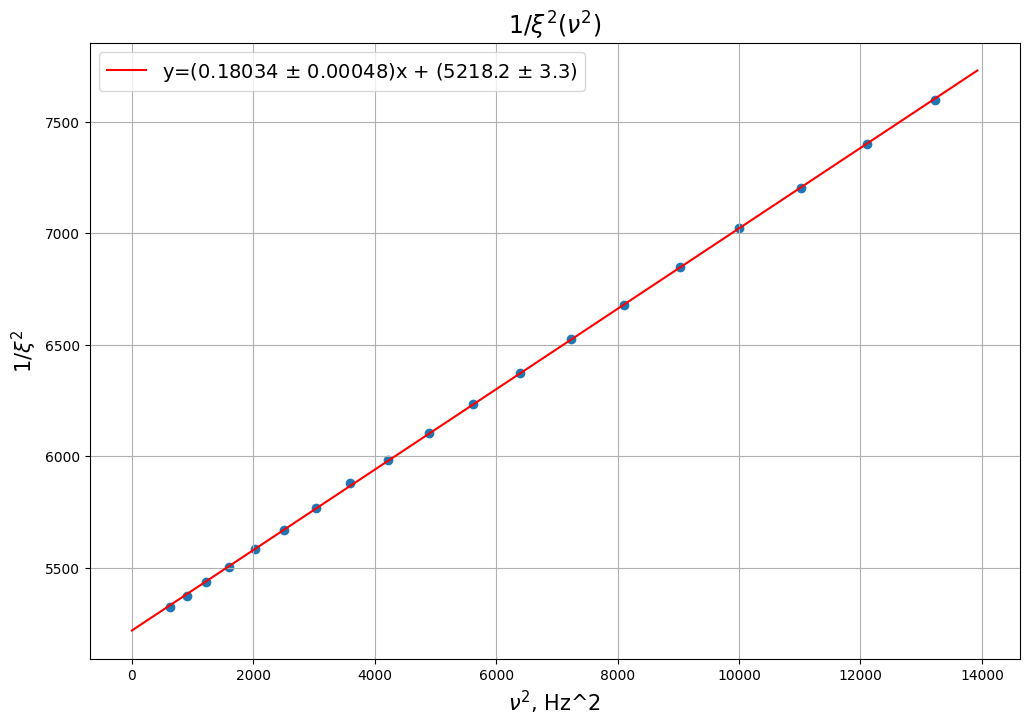

In [15]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$1/\xi^2(\nu^2)$", fontsize=17)
plt.xlabel(r"$\nu^2$, Hz^2", fontsize=15)
plt.ylabel(r"$1/\xi^2$", fontsize=15)
# plt.xlim(left=20, right=120)

plt.scatter(low_freq['f']**2, 1/(low_freq['xi']**2))

slc = slice(None)
X = low_freq.loc[slc, 'f']**2
Y = 1/(low_freq.loc[slc, 'xi']**2)

a, b, da, db, f = mnk(X, Y)
print(a, da, b, db)

x_mm = np.array([0, np.max(X)+700])
plt.plot(x_mm, f(x_mm), color='red', label=r'y=(0.18034 $\pm$ 0.00048)x + (5218.2 $\pm$ 3.3)')

plt.legend(fontsize=14)
# plt.savefig('../pictures/xi_nu_low_freq_linearized.eps')
plt.show()

In [16]:
c = b**0.5
dc = c * db / (2 * b)
print(c, dc)

A = 22.5 * 0.001; dA = 0
h = 1.5 * 0.001; dh = 0
mu_0 = 4*np.pi*10**-7

# sigma = a / (pi A h mu_0 c)

sigma = np.sqrt(a) / (np.pi * A * h * mu_0 * c)
dsigma = sigma * np.sqrt((da/(2*a))**2 + (dc/c)**2 + (dA/A)**2 + (dh/h)**2)

print(sigma * 10**-7, dsigma * 10**-7, 100 * dsigma/sigma)

72.23731554089717 0.023212850223094977
4.41216968576096 0.006145512273642366 0.13928549242961535


In [17]:
high_freq = pd.read_csv('high_freq.csv')
high_freq['phi']=np.pi * high_freq['p1']/high_freq['p2']

dp = 0.1
high_freq['psi'] = high_freq['phi'] - np.pi/2
high_freq['dpsi']=high_freq['phi'] * np.sqrt((dp/high_freq['p1'])**2 + (dp/high_freq['p2'])**2)

low_slc = slice(27)
high_slc = slice(27, None)

high_freq.head()

,f,I,U,p1,p2,phi,psi,dpsi
0,115,416.63,549.9,3.1,4.4,2.213395,0.642598,0.087341
1,125,409.57,572.4,5.8,8.1,2.249535,0.678739,0.047703
2,135,404.00,593.1,5.4,7.5,2.261947,0.691150,0.051616
3,145,398.87,611.2,5.1,7.0,2.288875,0.718078,0.055528
4,155,394.08,627.2,4.9,6.5,2.368278,0.797481,0.060527


0.00621285121358361 0.00022987549490259562 1.0138022916444944 3.700000000000033


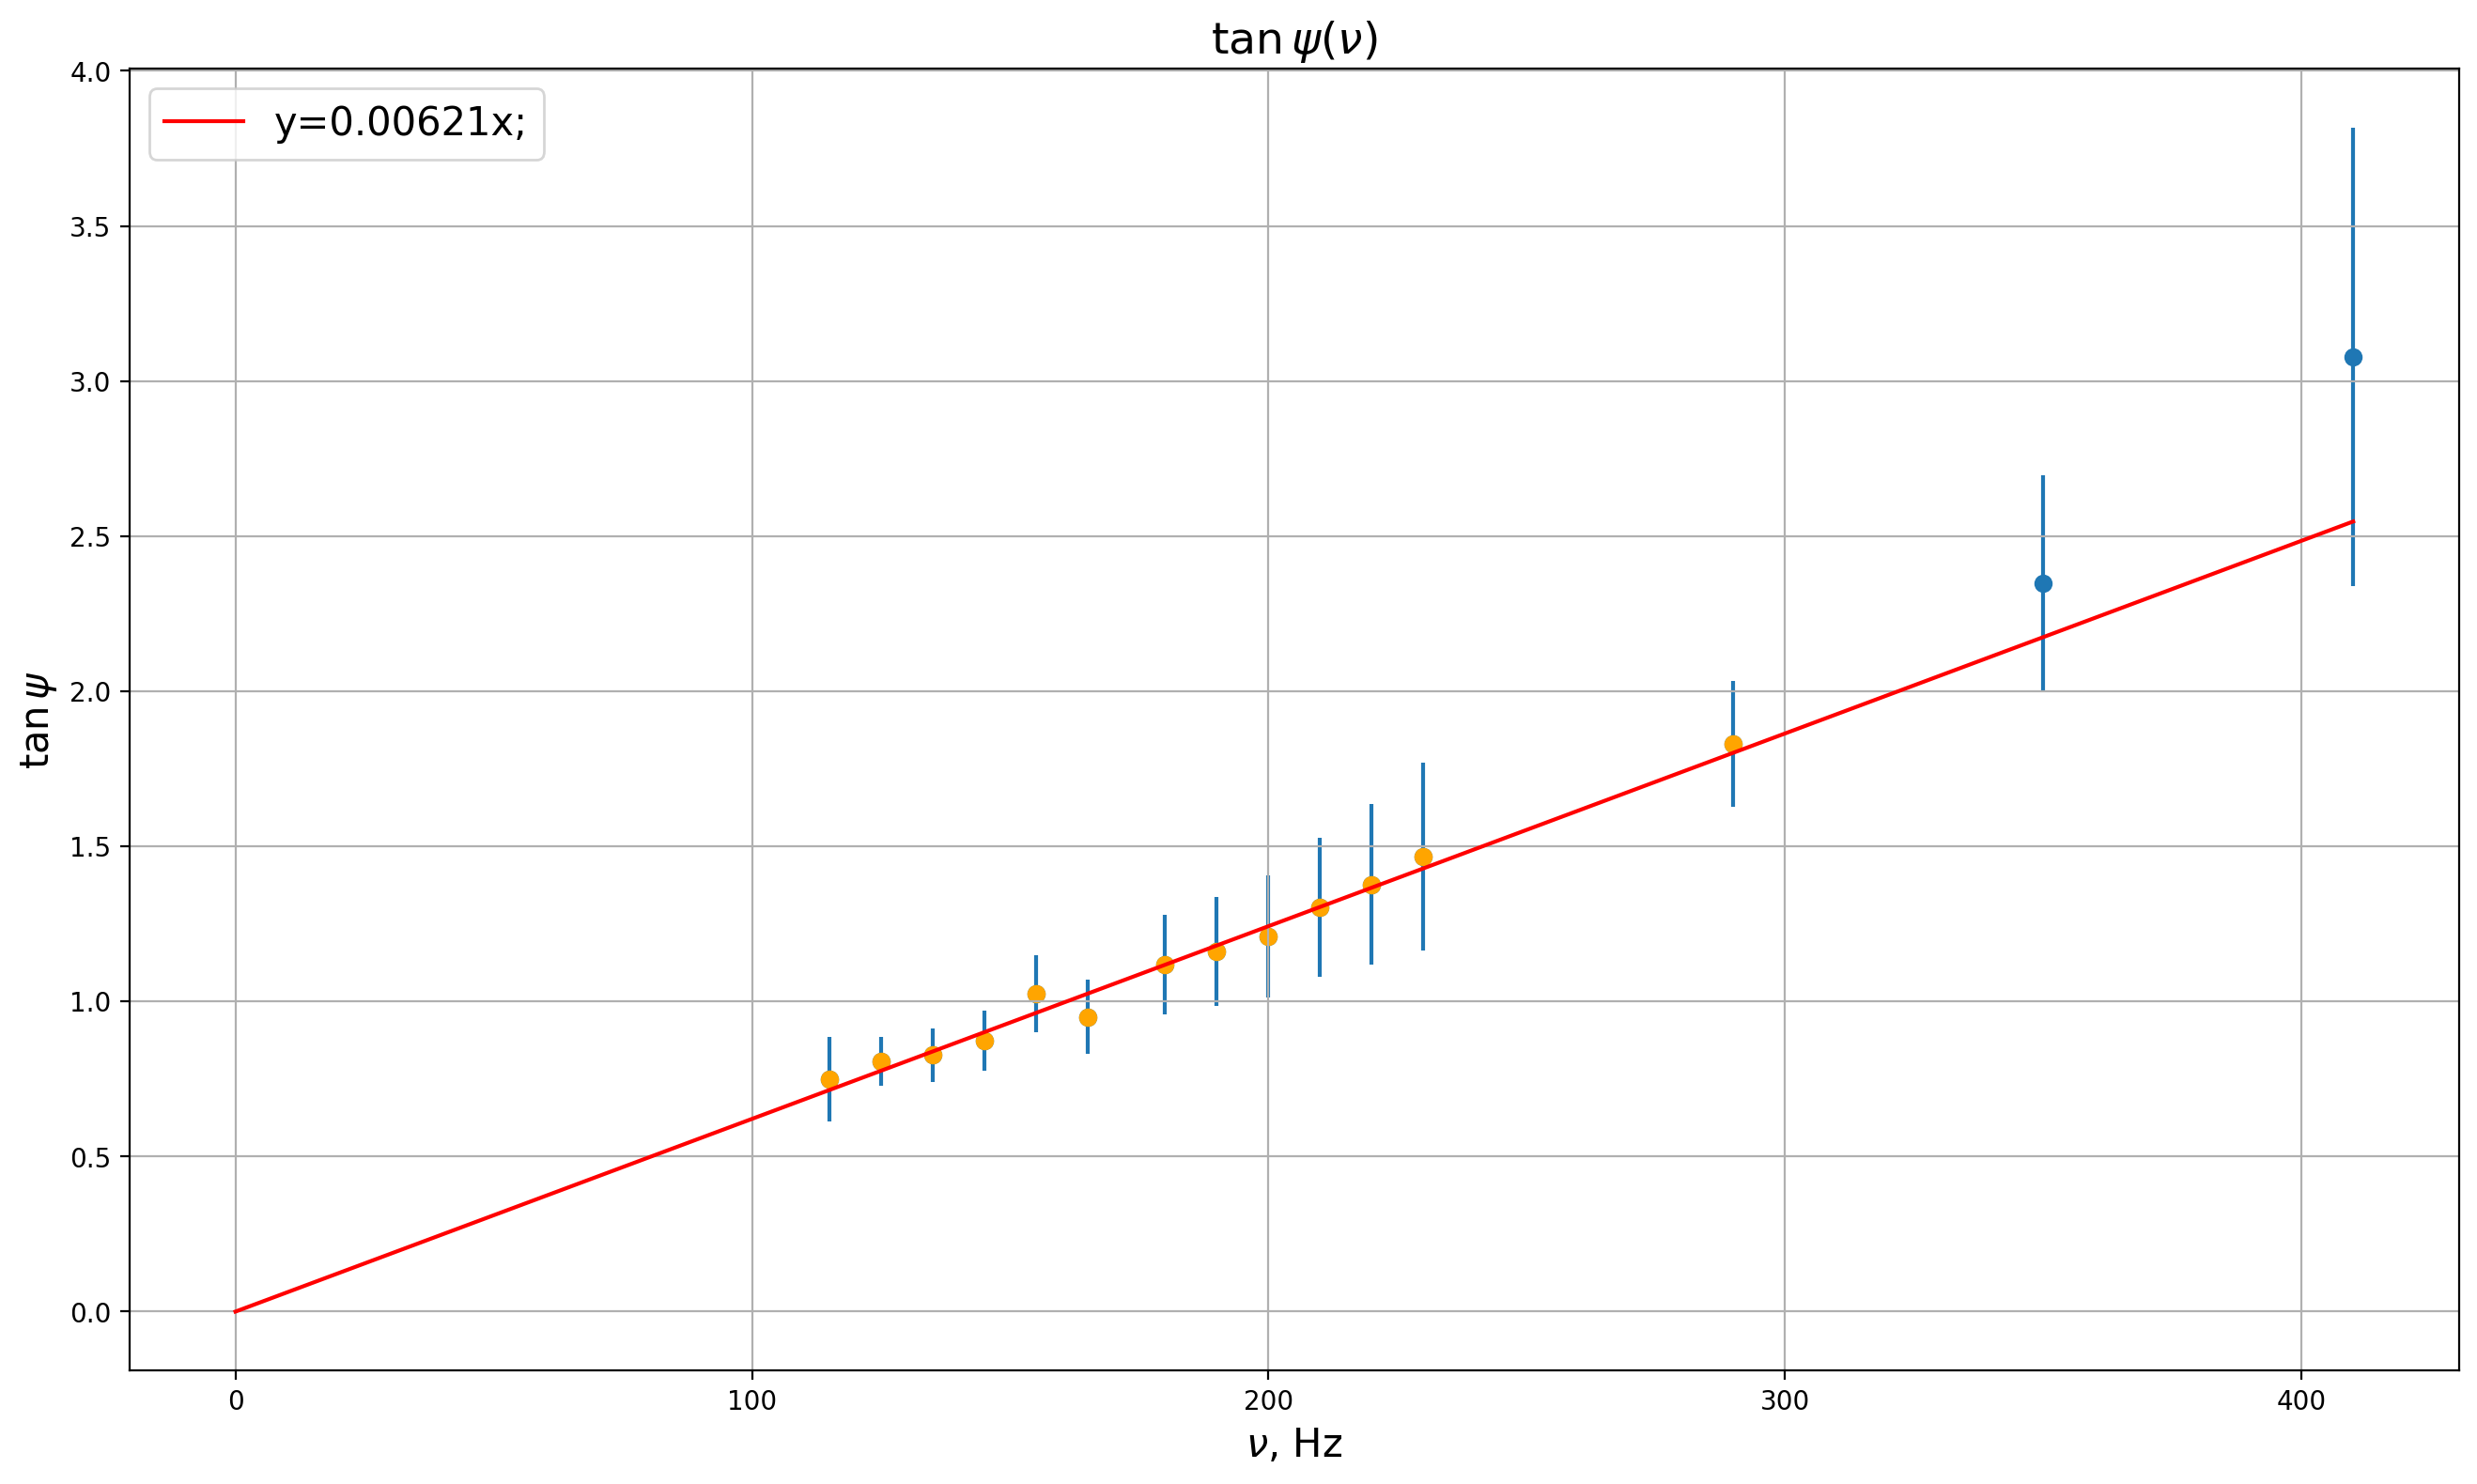

In [18]:
plt.figure(figsize=(16, 9), dpi=200)
plt.grid()
plt.title(r"$\tan\psi(\nu)$", fontsize=17)
plt.xlabel(r"$\nu$, Hz", fontsize=15)
plt.ylabel(r"$\tan \psi$", fontsize=15)

slc = slice(0, 14)
fit_slc = slice(0, 13)

X = (high_freq.loc[slc, 'f'])
Y = np.tan(high_freq.loc[slc, 'psi'])
dY = high_freq.loc[slc, 'dpsi'] / np.cos(high_freq.loc[slc, 'psi']) ** 2

plt.scatter(X, Y)
plt.errorbar(X, Y, yerr=dY, linestyle='', zorder=-2)

plt.scatter(X[fit_slc], Y[fit_slc], c='orange')

a, b, da, db, f, chi_min = chi_fit(X[fit_slc], Y[fit_slc], dY[fit_slc], force_intercept=True)

print(a, da, chi_min, 100*da/a)

x_mm = np.array([0, np.max(X)])
plt.plot(x_mm, f(x_mm), c='red', label=r'y=0.00621x;')
plt.legend(fontsize=15, loc='upper left')

# plt.savefig('../pictures/tg_psi_nu_line.eps')

plt.show()

0.00621285121358361 0.00022987549490259562 0 0 1.0138022916444944


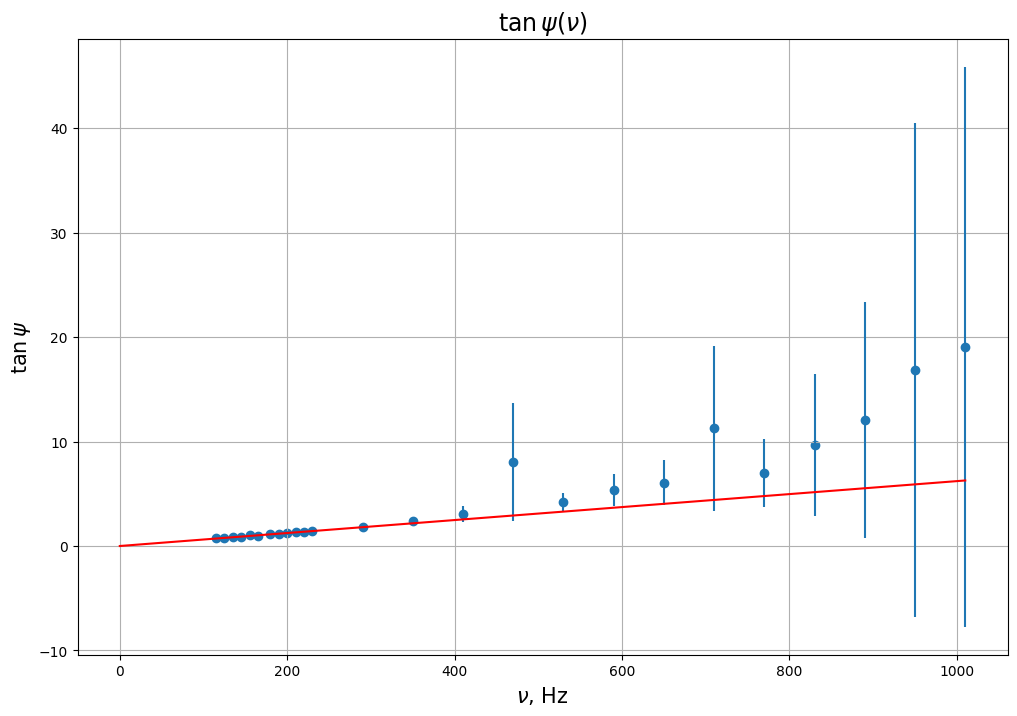

In [19]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$\tan\psi(\nu)$", fontsize=17)
plt.xlabel(r"$\nu$, Hz", fontsize=15)
plt.ylabel(r"$\tan \psi$", fontsize=15)

slc = slice(0, 24)

X = (high_freq.loc[slc, 'f'])
Y = np.tan(high_freq.loc[slc, 'psi'])
dY = high_freq.loc[slc, 'dpsi'] / np.cos(high_freq.loc[slc, 'psi']) ** 2

plt.scatter(X, Y)
plt.errorbar(X, Y, yerr=dY, linestyle='')

a, b, da, db, f, chi_min = chi_fit(X[fit_slc], Y[fit_slc], dY[fit_slc], force_intercept=True)

print(a, da, b, db, chi_min)

x_mm = np.array([0, np.max(X)])
plt.plot(x_mm, f(x_mm), c='red')

# plt.savefig('../pictures/tg_psi_nu_no_line.eps')

plt.show()

In [20]:
# a = pi A h sigma mu_0
# sigma = a / (pi A h mu_0)

sigma = a / (np.pi * A * h * mu_0)
dsigma = sigma * np.sqrt((da/a)**2 + (dA/A)**2 + (dh/h)**2)
print(sigma * 10**-7, dsigma * 10**-7, 100*dsigma/sigma)

4.662914361140934 0.17252783136221608 3.700000000000033


0.01949068374079098 0.0007523403923945279 3.8599999999999803


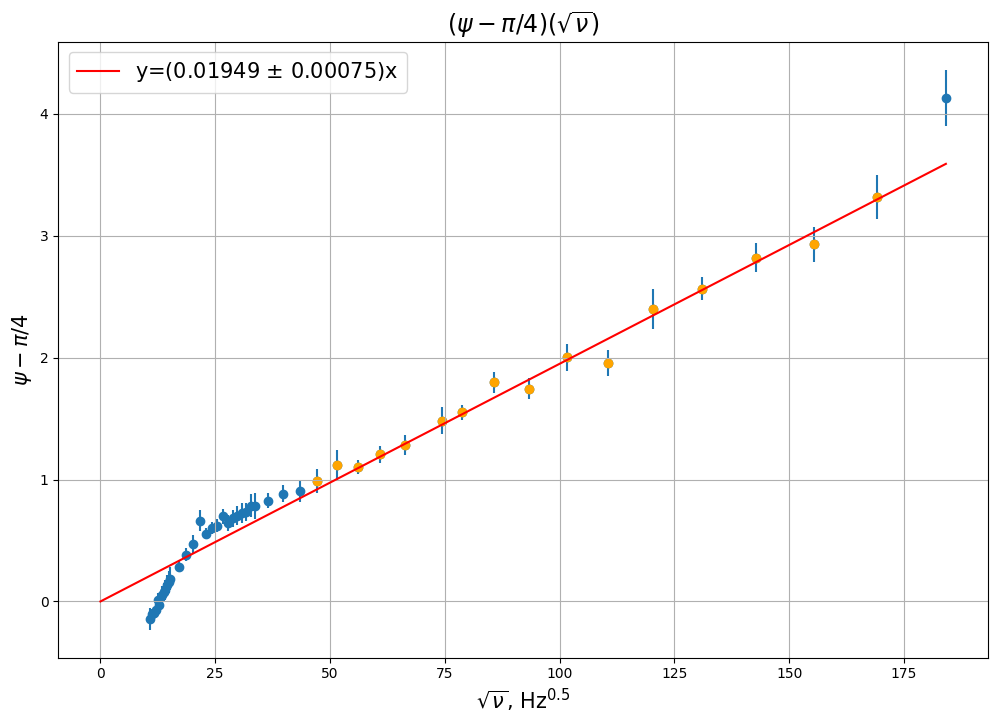

In [21]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$(\psi-\pi/4)(\sqrt{\nu})$", fontsize=17)
plt.xlabel(r"$\sqrt{\nu}$, Hz$^{0.5}$", fontsize=15)
plt.ylabel(r"$\psi-\pi/4$", fontsize=15)

slc = slice(0, None)
fit_slc = slice(30, 45)

Y = high_freq.loc[slc, "psi"] - np.pi/4
dY = high_freq.loc[slc, "dpsi"]
X = np.sqrt(high_freq.loc[slc, "f"])


plt.scatter(X, Y)
plt.errorbar(X, Y, yerr=dY, linestyle='', zorder=-1)

plt.scatter(X.loc[fit_slc], Y.loc[fit_slc], c='orange')

X_fit = X.loc[fit_slc].to_numpy()
Y_fit = Y.loc[fit_slc].to_numpy()
dY_fit = dY.loc[fit_slc].to_numpy()
# a, b, da, db, f, chi_min = chi_fit(X_fit, Y_fit, dY_fit, force_intercept=True)
# a, b, da, db, f = mnk_intercept(X_fit, Y_fit)
a, da, f = mnk_intercept(X_fit, Y_fit)

print(a, da, 100*da/a)

x_mm = np.array([0, np.max(X)])
plt.plot(x_mm, f(x_mm), c='red', label=r'y=(0.01949 $\pm$ 0.00075)x')
plt.legend(fontsize=15, loc='upper left')

# plt.savefig('../pictures/psi_sqrt_nu.eps')
plt.show()

In [22]:
# a^2 = h^2 pi mu_0 sigma

sigma = a**2 / (h**2 * np.pi * mu_0)
dsigma = sigma * np.sqrt((2*da/a)**2 + (2*dh/h)**2)

print(sigma * 10**-7, dsigma * 10**-7, 100*dsigma/sigma)

4.276730603548853 0.3301636025939698 7.719999999999961


In [23]:
inductance = pd.read_csv("inductance.csv")

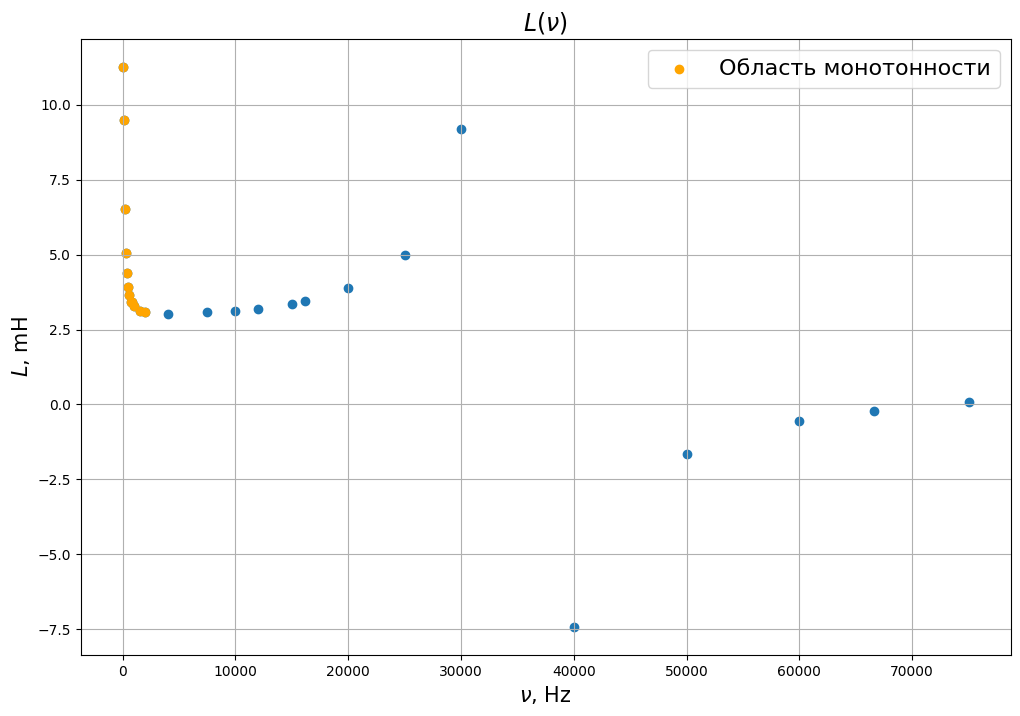

In [24]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$L(\nu)$", fontsize=17)
plt.xlabel(r"$\nu$, Hz", fontsize=15)
plt.ylabel(r"$L$, mH", fontsize=15)

F = inductance['f']
L = inductance['L']

plt_slc = slice(0, -4)
monotonous_slc = slice(0, 12)
plt.scatter(F[plt_slc], L[plt_slc])
plt.scatter(F[monotonous_slc], L[monotonous_slc], c='orange', label='Область монотонности')

plt.legend(loc='upper right', fontsize=16)
# plt.savefig("../pictures/L_nu.eps")

35.75876370099994 1.0656111582898025 7


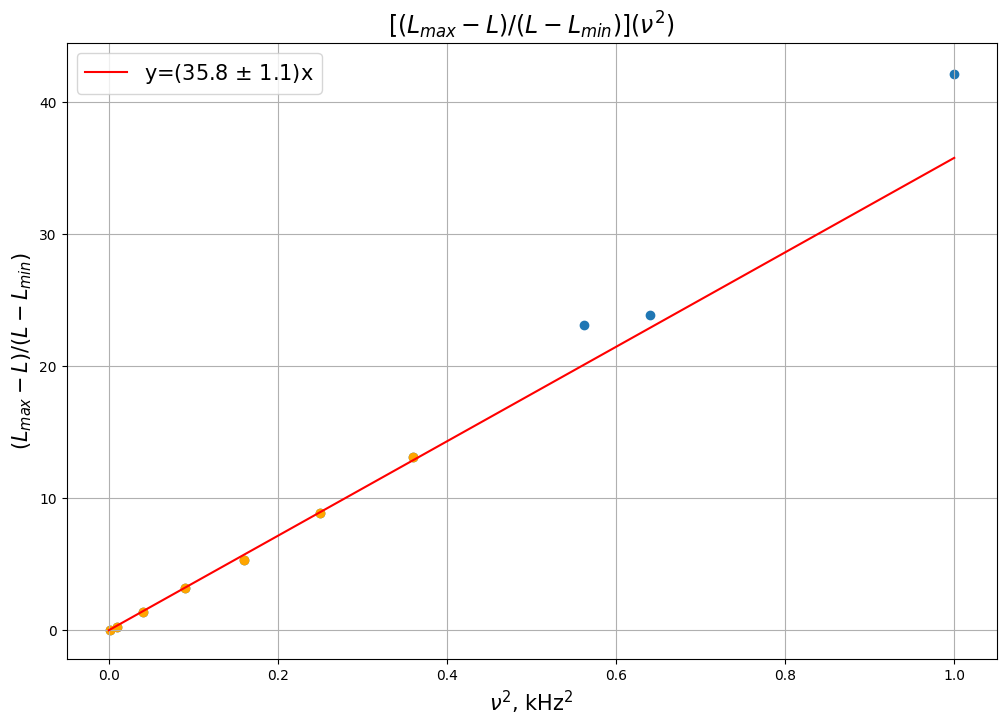

In [25]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title(r"$[(L_{max} - L)/(L - L_{min})](\nu^2)$", fontsize=17)
plt.xlabel(r"$\nu^2$, kHz$^2$", fontsize=15)
plt.ylabel(r"$(L_{max} - L)/(L - L_{min})$", fontsize=15)

plt_slc = slice(None, 10)

L_max, L_min = L[monotonous_slc].max(), L[monotonous_slc].min()
dL = 0.01

Y = ((L_max - L) / (L - L_min))[plt_slc]
X = (F[plt_slc]/1000)**2
dY = np.sqrt(((dL/(L-L_min))**2 + (L*dL/(L-L_min))**2 + (L*dL/(L-L_min))**2)[plt_slc])

fit_slc = slice(None, -3)

plt.scatter(X,Y)
plt.scatter(X[fit_slc], Y[fit_slc], c='orange')
plt.errorbar(X, Y, yerr=dY, linestyle='', zorder=-1)

a, da, f = mnk_intercept(X[fit_slc], Y[fit_slc])

x_mm = np.array([0, X.max()])

plt.plot(x_mm, a*x_mm, c='red', label="y=(35.8 $\pm$ 1.1)x")
plt.legend(fontsize=15, loc='upper left')

# plt.savefig('../pictures/L_nu_linearized.eps')
print(a, da, len(X[fit_slc]))

In [26]:
# sqrt(a) = pi A h mu_0 sigma

sigma = np.sqrt(a) / (1000 * np.pi * A * h * mu_0)
dsigma = sigma * np.sqrt((da/(2*a))**2 + (dA/A)**2 + (dh/h)**2)

print(sigma * 10**-7, dsigma * 10**-7, 100*dsigma/sigma)

4.488050487674251 0.0668719522663466 1.490000000000006


In [27]:
# f - frequency
# I - current
# U - voltage
# r - ratio H1/H0
# dr - error of r

c = 72.23731554089719
dc = 0.023212850223015672
xi_data = pd.DataFrame(columns=['f', 'I', 'U', 'r', 'dr'])
xi_data[['f', 'I', 'U']] = pd.concat([low_freq[['f', 'I', 'U']], high_freq[['f', 'I', 'U']][1:]], ignore_index=True)

xi_data['r'] = c * xi_data['U'] / (xi_data['f'] * xi_data['I'])
xi_data['dr'] = xi_data['r'] / c * dc
xi_data.head(5)

,f,I,U,r,dr
0,25,473.18,162.1,0.989870,0.000318
1,30,471.12,192.8,0.985407,0.000317
2,35,468.87,222.6,0.979865,0.000315
3,40,466.29,251.4,0.973668,0.000313
4,45,463.40,279.1,0.966836,0.000311


In [28]:
def theor_r_wrapper(f, sigma=1, a=1, h=1):
    return lambda x: f(x, sigma, a, h)

def theoretical_r(freq, sigma, a, h):
    mu_0 = 4*np.pi * 10**-7
    alpha = np.sqrt((.0 + 1.j) * 2 * np.pi * freq * sigma * mu_0)
    
    denominator = np.cosh(alpha * h) + 0.5 * alpha * a * np.sinh(alpha * h)
    
    return 1/np.abs(denominator)

theoretical_r = theor_r_wrapper(theoretical_r, sigma=4.4121*10**7, a=22.5*10**-3, h=1.5*10**-3)

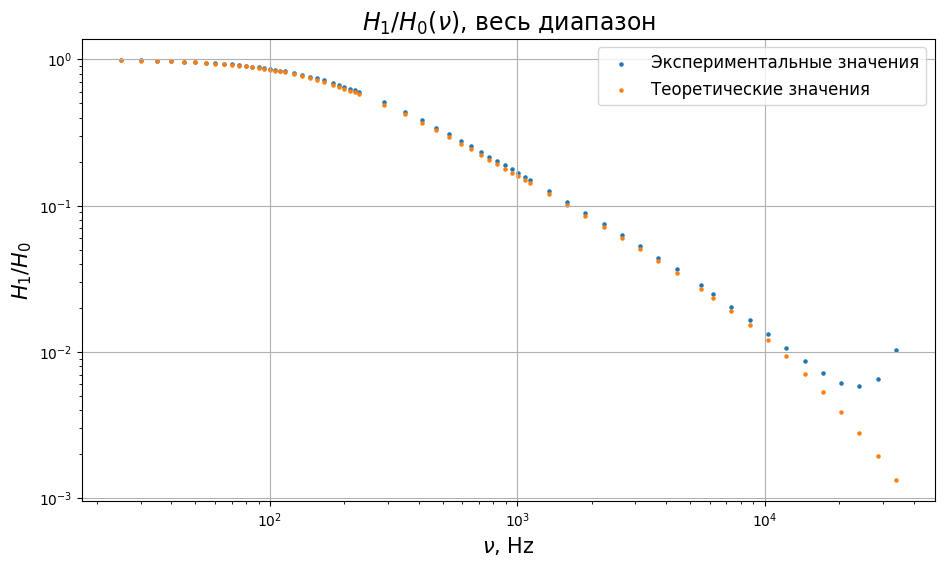

In [29]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot()
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

ax.set_title(r"$H_1/H_0(\nu)$, весь диапазон", fontsize=17)
ax.set_xlabel(r"$\nu$, Hz", fontsize=15)
ax.set_ylabel(r"$H_1/H_0$", fontsize=15)

plt_slc = slice(0, None)

X = xi_data.loc[plt_slc, 'f'].to_numpy()
Y = xi_data.loc[plt_slc, 'r'].to_numpy()

ax.scatter(X, Y, s=5, label='Экспериментальные значения')
ax.scatter(X, theoretical_r(X), s=5,  label='Теоретические значения')
ax.legend(loc='upper right', fontsize=12)

# plt.savefig('../pictures/all_freq_ratio.eps')

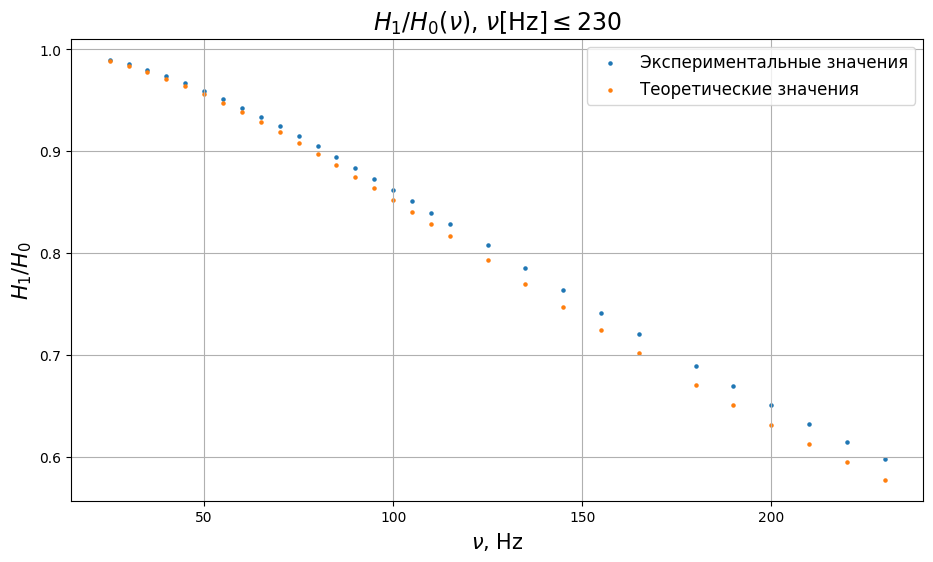

In [30]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.grid()

ax.set_title(r"$H_1/H_0(\nu)$, $\nu[$Hz$] \leq 230$", fontsize=17)
ax.set_xlabel(r"$\nu$, Hz", fontsize=15)
ax.set_ylabel(r"$H_1/H_0$", fontsize=15)

plt_slc = slice(0, 29)

X = xi_data.loc[plt_slc, 'f'].to_numpy()
Y = xi_data.loc[plt_slc, 'r'].to_numpy()

ax.scatter(X, Y, s=5, label='Экспериментальные значения')
ax.scatter(X, theoretical_r(X), s=5,  label='Теоретические значения')
ax.legend(loc='upper right', fontsize=12)

# plt.savefig('../pictures/low_freq_ratio.eps')

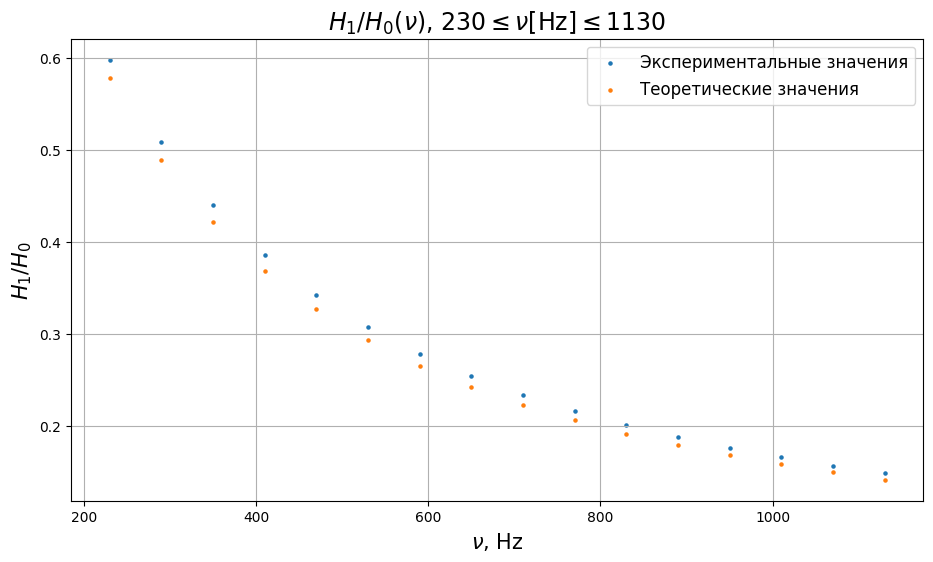

In [31]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot()
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.grid()

ax.set_title(r"$H_1/H_0(\nu)$, $230 \leq \nu[$Hz$] \leq 1130$", fontsize=17)
ax.set_xlabel(r"$\nu$, Hz", fontsize=15)
ax.set_ylabel(r"$H_1/H_0$", fontsize=15)

plt_slc = slice(29, 44)

X = xi_data.loc[plt_slc, 'f'].to_numpy()
Y = xi_data.loc[plt_slc, 'r'].to_numpy()

ax.scatter(X, Y, s=5, label='Экспериментальные значения')
ax.scatter(X, theoretical_r(X), s=5,  label='Теоретические значения')
ax.legend(loc='upper right', fontsize=12)

# plt.savefig('../pictures/mid_freq_ratio.eps')

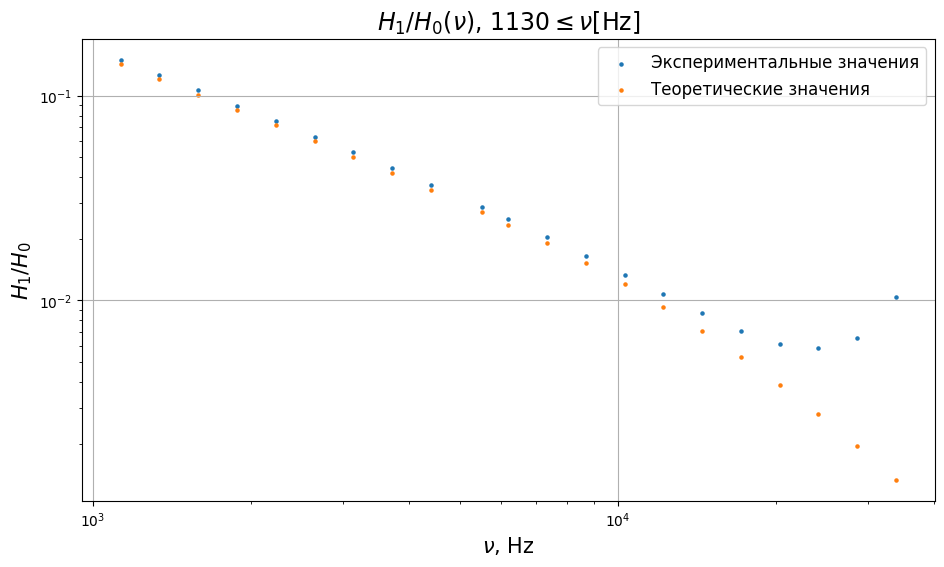

In [32]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot()
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

ax.set_title(r"$H_1/H_0(\nu)$, $1130 \leq \nu[$Hz$]$", fontsize=17)
ax.set_xlabel(r"$\nu$, Hz", fontsize=15)
ax.set_ylabel(r"$H_1/H_0$", fontsize=15)

plt_slc = slice(44, None)

X = xi_data.loc[plt_slc, 'f'].to_numpy()
Y = xi_data.loc[plt_slc, 'r'].to_numpy()

ax.scatter(X, Y, s=5, label='Экспериментальные значения')
ax.scatter(X, theoretical_r(X), s=5,  label='Теоретические значения')
ax.legend(loc='upper right', fontsize=12)
# plt.savefig('../pictures/high_freq_ratio.eps')

In [33]:
exp_r = xi_data['r'].to_numpy()
theor_r = theoretical_r(xi_data['f']).to_numpy()
f = xi_data['f'].to_numpy()

In [34]:
exp_r

array([0.98987014, 0.98540743, 0.97986505, 0.97366774, 0.96683618,
       0.95929398, 0.95129788, 0.94219818, 0.93378792, 0.92446516,
       0.91482794, 0.90487468, 0.89436463, 0.88397515, 0.8730082 ,
       0.86210536, 0.8511091 , 0.83979428, 0.82864659, 0.80764977,
       0.78555101, 0.76338842, 0.74173975, 0.72047477, 0.68970228,
       0.67002234, 0.6509033 , 0.6323999 , 0.61479472, 0.59773029,
       0.50881232, 0.43960606, 0.38531183, 0.34217792, 0.30723496,
       0.27850327, 0.25442701, 0.23407788, 0.21668208, 0.20161182,
       0.18841562, 0.17682477, 0.16654652, 0.15738619, 0.1491573 ,
       0.12618509, 0.10624088, 0.08950966, 0.07528215, 0.06317414,
       0.05289146, 0.04416197, 0.03671985, 0.02853062, 0.02500092,
       0.02042768, 0.01654691, 0.01333079, 0.01070047, 0.00865056,
       0.00712198, 0.00613474, 0.00583189, 0.00654236, 0.0103597 ])

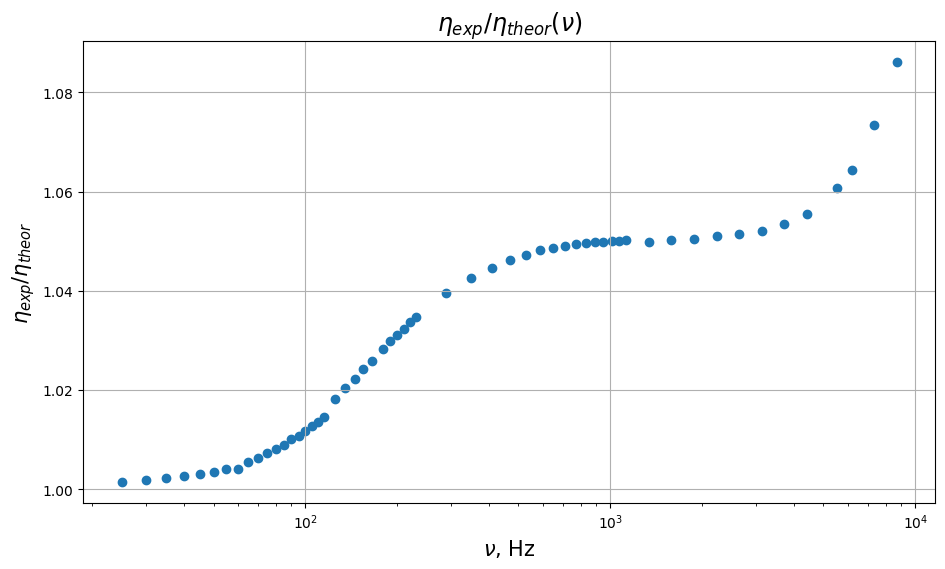

In [35]:
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot()
ax.set_xscale('log')

ax.grid()

ax.set_title(r"$\eta_{exp}/\eta_{theor} (\nu)$", fontsize=17)
ax.set_xlabel(r"$\nu$, Hz", fontsize=15)
ax.set_ylabel(r"$\eta_{exp}/\eta_{theor}$", fontsize=15)

plt_slc = slice(None, 57)
X = f[plt_slc]
Y = (exp_r / theor_r)[plt_slc]
ax.scatter(X, Y)
# plt.savefig('../pictures/reduction_ratio.eps')